# Compute the LateX cutflow tables
- Will load the pkl files that contain the cutflows and the sumgenweight
- Will scale the events by the cross section
- Will save the yields in a dictionnary called ```cutflows -> Dict()```
- Will make the LateX table using the function ```make_composition_table()```

In [1]:
import glob
import json
import os
import pickle as pkl
import sys

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import yaml
from scipy.special import softmax
from sklearn.metrics import auc, roc_curve

sys.path
sys.path.append("../python/")

import utils

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

pd.options.mode.chained_assignment = None

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

# Read cutflows from pkl

In [5]:
"""
For ../eos/Dec7_2016

cuts["mu"] += [
        "Trigger",
        "METFilters",
        "OneLep",
        "NoTaus",
        "LepIso",
        "LepMiniIso",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
]
cuts["ele"] += [
        "Trigger",
        "METFilters",
        "OneLep",
        "NoTaus",
        "LepIso",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
]
"""

'\nFor ../eos/Dec7_2016\n\ncuts["mu"] += [\n        "Trigger",\n        "METFilters",\n        "OneLep",\n        "NoTaus",\n        "LepIso",\n        "LepMiniIso",\n        "OneCandidateJet",\n        "CandidateJetpT",\n        "LepInJet",\n        "JetLepOverlap",\n        "dPhiJetMETCut",\n]\ncuts["ele"] += [\n        "Trigger",\n        "METFilters",\n        "OneLep",\n        "NoTaus",\n        "LepIso",\n        "OneCandidateJet",\n        "CandidateJetpT",\n        "LepInJet",\n        "JetLepOverlap",\n        "dPhiJetMETCut",\n]\n'

In [11]:
def get_sum_sumgenweight(pkl_files, year, sample):
    """Load and sum the sumgenweight of each pkl file."""
    
    sum_sumgenweight = 0
    for ifile in pkl_files:
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)            
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]

    return sum_sumgenweight


def get_xsecweight(pkl_files, year, ch, sample, is_data):
    
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity[ch][year]) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

def get_cutflow(pkl_files, year, ch, sample, is_data):
    """
    Get cutflow from metadata but multiply by xsec-weight
    """
    xsec_weight = get_xsecweight(pkl_files, year, ch, sample, is_data)


    cuts = {
        "mu": ["sumgenweight"],
        "ele": ["sumgenweight"],
    }
        
    cuts["mu"] += [
        "Trigger",
        "METFilters",
        "OneLep",
        "LepMiniIso",        
        "NoTaus",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
        "MET",        
    ]
    cuts["ele"] += [
        "Trigger",
        "METFilters",
        "OneLep",
        "NoTaus",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
        "MET",
    ]
        
    if year == "2018":
        cuts["mu"] += ["HEMCleaning"]
        cuts["ele"] += ["HEMCleaning"]
        
    evyield = dict.fromkeys(cuts[ch], 0)
    for ik, pkl_file in enumerate(pkl_files):
        with open(pkl_file, "rb") as f:
            metadata = pkl.load(f)
            
        cutflows = metadata[sample][year]["cutflows"][ch]

        for key in evyield.keys():

            if key == "sumgenweight":
                evyield[key] += metadata[sample][year][key] * xsec_weight
            else:
                
                try:
                    evyield[key] += cutflows[key] * xsec_weight
                except KeyError:
                    evyield[key] += cutflows["AtLeastOneFatJet"] * xsec_weight            
    return evyield

In [12]:
### This is your configuration. specefy which channels, years, samples, and directory of pkl files to use.
channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

# samples_dir = {
#     "2016":    "../eos/Dec7_2016",
#     "2016APV": "../eos/Dec7_2016APV",    
#     "2017":    "../eos/Dec7_2017",    
#     "2018":    "../eos/Dec7_2018",    
# }
samples_dir = {
    "2016":    "../eos/Jan30_fixPUJetID_2016",
    "2016APV": "../eos/Jan30_fixPUJetID_2016APV",
    "2017":    "../eos/Jan30_fixPUJetID_2017",
    "2018":    "../eos/Jan30_fixPUJetID_2018",    
}

In [13]:
cutflows = {}
for year in years:
    print(f"Processing year {year}")
    
    cutflows[year] = {}
    
    for ch in channels:
        print(f"  {ch} channel")
        cutflows[year][ch] = {}

        condor_dir = os.listdir(samples_dir[year])

        for sample in condor_dir:

            # get a combined label to combine samples of the same process
            for key in utils.combine_samples:
                if key in sample:
                    sample_to_use = utils.combine_samples[key]
                    break
                else:
                    sample_to_use = sample

            if sample_to_use not in samples:
                continue

            
                
            is_data = False
            if sample_to_use == "Data":
                is_data = True

            out_files = f"{samples_dir[year]}/{sample}/outfiles/"
            pkl_files = glob.glob(f"{out_files}/*.pkl")

            if len(pkl_files) == 0:
                continue
            if sample_to_use not in cutflows[year][ch].keys():
                cutflows[year][ch][sample_to_use] = get_cutflow(pkl_files, year, ch, sample, is_data)
            else:
                temp = get_cutflow(pkl_files, year, ch, sample, is_data)
                for key in cutflows[year][ch][sample_to_use]:
                    cutflows[year][ch][sample_to_use][key] += temp[key]
                    
    print(f"------------------------------------------")                    

Processing year 2018
  ele channel


FileNotFoundError: [Errno 2] No such file or directory: '../eos/Jan30_fixPUJetID_2018'

In [ ]:
cutflows["2016"]["mu"]["ttH"]     # take a quick look

In [9]:
# add ttH to 2016APV
cutflows["2016APV"]["ele"]["ttH"], cutflows["2016APV"]["mu"]["ttH"] = {}, {}
for cut in cutflows["2016"]["mu"]["ttH"]:
    cutflows["2016APV"]["mu"]["ttH"][cut] = 0
    cutflows["2016APV"]["ele"]["ttH"][cut] = 0    

KeyError: '2016APV'

In [10]:
cutflows["2016APV"]["mu"]["ttH"]     # take a quick look

KeyError: '2016APV'

# Combine different channels

In [289]:
# common_cuts = [
#     "sumgenweight",
#     "HEMCleaning",
#     "Trigger",
#     "METFilters",
#     "OneLep",
#     "NoTaus",
#     "LepIso",
#     "LepMiniIso",
#     "OneCandidateJet",
#     "CandidateJetpT",
#     "LepInJet",
#     "JetLepOverlap",
#     "dPhiJetMETCut",    
# ]
common_cuts = [
    "sumgenweight",
    "Trigger",
    "METFilters",
    "OneLep",
    "LepMiniIso",    
    "NoTaus",
    "OneCandidateJet",
    "CandidateJetpT",
    "LepInJet",
    "JetLepOverlap",
    "dPhiJetMETCut",   
    "MET",    
    "HEMCleaning",
    
]
def combine_channels(cutflows):
    """
    Must add lepminiso cutflow to electron channel.
    Will add to extra keys to the channels,
        1. `ele_new`: which contains the mini-isolation label to match the mu channel (the yield doesn't change)
        2. `lep`: which is the sum of `ele_new` and `mu`
    """
    
    for year in cutflows.keys():
        cutflows[year]["ele_new"] = {}   

        for sample in cutflows[year]["ele"].keys():
            cutflows[year]["ele_new"][sample] = {}

            for cut in common_cuts:
                if (year != "2018") and (cut == "HEMCleaning"):
                    continue

                if cut != "LepMiniIso":
                    cutflows[year]["ele_new"][sample][cut] = cutflows[year]["ele"][sample][cut]
                else:
                    cutflows[year]["ele_new"][sample][cut] = cutflows[year]["ele"][sample]["OneLep"]

    # combine both channels
    cutflows_new = {}
    for year in cutflows.keys():
        cutflows_new[year] = {}
        cutflows_new[year]["lep"] = {}
        
        for ch in ["mu", "ele_new"]:
            for sample in cutflows[year][ch]:
                                
                if sample not in cutflows_new[year]["lep"]:
                    cutflows_new[year]["lep"][sample] = {}
                
                for cut in cutflows[year][ch][sample]:
                    
                    if (year != "2018") and (cut == "HEMCleaning"):
                        continue
                    
                    if cut not in cutflows_new[year]["lep"][sample]:
                        cutflows_new[year]["lep"][sample][cut] = cutflows[year][ch][sample][cut]
                    else:
                        cutflows_new[year]["lep"][sample][cut] += cutflows[year][ch][sample][cut]
        cutflows[year] = {**cutflows[year], **cutflows_new[year]}
        
    return cutflows

In [290]:
cutflows = combine_channels(cutflows)

In [291]:
cutflows["2018"].keys()

dict_keys(['ele', 'mu', 'ele_new', 'lep'])

In [292]:
cutflows["2018"]["ele_new"]["WJetsLNu"]

{'sumgenweight': 823193409.7852464,
 'Trigger': 91673394.41882026,
 'METFilters': 91649009.31886779,
 'OneLep': 66052489.22276579,
 'LepMiniIso': 66052489.22276579,
 'NoTaus': 66052489.22276579,
 'OneCandidateJet': 2921922.857708171,
 'CandidateJetpT': 1229365.7783122507,
 'LepInJet': 473763.1757747547,
 'JetLepOverlap': 148098.08630271634,
 'dPhiJetMETCut': 118893.06163114097,
 'MET': 91768.29670131888,
 'HEMCleaning': 79842.49741111886}

In [293]:
cutflows["2018"]["mu"]["WJetsLNu"]

{'sumgenweight': 822721784.6401421,
 'Trigger': 137298031.4402536,
 'METFilters': 137257984.86539474,
 'OneLep': 109701738.56739485,
 'LepMiniIso': 109513323.52549933,
 'NoTaus': 94810280.09675619,
 'OneCandidateJet': 3442911.5745268194,
 'CandidateJetpT': 1443661.209322816,
 'LepInJet': 515757.1668822607,
 'JetLepOverlap': 180968.69191483103,
 'dPhiJetMETCut': 146700.4440684151,
 'MET': 115269.54203509261,
 'HEMCleaning': 99751.28014201869}

In [294]:
cutflows["2018"]["lep"]["WJetsLNu"]

{'sumgenweight': 1645915194.4253883,
 'Trigger': 228971425.85907385,
 'METFilters': 228906994.1842625,
 'OneLep': 175754227.79016066,
 'LepMiniIso': 175565812.74826512,
 'NoTaus': 160862769.31952196,
 'OneCandidateJet': 6364834.43223499,
 'CandidateJetpT': 2673026.9876350667,
 'LepInJet': 989520.3426570154,
 'JetLepOverlap': 329066.77821754734,
 'dPhiJetMETCut': 265593.5056995561,
 'MET': 207037.83873641148,
 'HEMCleaning': 179593.77755313757}

# Combine different years

In [295]:
def combine_years(cutflows):
    """Will remove the HEM cleaning cutflow from 2018 first."""
    
    whatever_year = list(cutflows.keys())[0]
    channels = cutflows[whatever_year].keys()
    
    # combine all years
    cutflows_new = {}
    cutflows_new["Run2"] = {}
    
    for ch in channels:
        cutflows_new["Run2"][ch] = {}
        
        for year in cutflows:
            for sample in cutflows[year][ch]:
                
                if sample not in cutflows_new["Run2"][ch]:
                    cutflows_new["Run2"][ch][sample] = {}

                for cut in cutflows[year][ch][sample]:
                    if "HEM" in cut:
                        continue
                    if cut not in cutflows_new["Run2"][ch][sample]:
                        cutflows_new["Run2"][ch][sample][cut] = cutflows[year][ch][sample][cut]
                    else:
                        cutflows_new["Run2"][ch][sample][cut] += cutflows[year][ch][sample][cut]

    cutflows = {**cutflows, **cutflows_new}

    return cutflows

In [296]:
cutflows = combine_years(cutflows)

In [297]:
cutflows["2016"]["ele"].keys()

dict_keys(['VBF', 'WJetsLNu', 'Data', 'VH', 'TTbar', 'SingleTop', 'ggF', 'DYJets', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

In [298]:
cutflows.keys()

dict_keys(['2018', '2017', '2016', '2016APV', 'Run2'])

In [299]:
cutflows["Run2"].keys()

dict_keys(['ele', 'mu', 'ele_new', 'lep'])

# Combine non-dominant backgrounds

In [300]:
# combine non-dominant backgrounds under others
dominant_bkgs = ["WJetsLNu", "QCD", "TTbar"]
signals = ["ggF", "VH", "VBF", "ttH"]

for year in cutflows:
    for ch in cutflows[year]:
        cutflows[year][ch]["Others"] = dict.fromkeys(cutflows[year][ch]["WJetsLNu"], 0)
        for sample in cutflows[year][ch]:
            if sample == "Data":
                continue
            if sample not in signals+dominant_bkgs:
                for cut in cutflows[year][ch][sample]:
                    cutflows[year][ch]["Others"][cut] += cutflows[year][ch][sample][cut]

In [301]:
cutflows["2018"]["ele"].keys()

dict_keys(['VBF', 'WJetsLNu', 'VH', 'TTbar', 'SingleTop', 'ggF', 'DYJets', 'WZQQ', 'QCD', 'Data', 'Diboson', 'ttH', 'Others'])

In [302]:
cutflows["2018"]["lep"]["Others"]

{'sumgenweight': 1553503591.0102324,
 'Trigger': 113019350.52840021,
 'METFilters': 112985789.41838025,
 'OneLep': 64432028.968634166,
 'LepMiniIso': 64226473.09818638,
 'NoTaus': 59962970.190428056,
 'OneCandidateJet': 1331196.0371565917,
 'CandidateJetpT': 549634.3213283535,
 'LepInJet': 286284.8000497053,
 'JetLepOverlap': 112761.42936466096,
 'dPhiJetMETCut': 88222.89828459748,
 'MET': 56229.69331775374,
 'HEMCleaning': 48537.38760557984}

# LateX cutflow table

In [303]:
# cuts = {
#     "mu": [
#         "sumgenweight",
#         "HEMCleaning",        
#         "Trigger",
#         "METFilters",
#         "OneLep",
#         "NoTaus",
#         "LepIso",
#         "LepMiniIso",
#         "OneCandidateJet",
#         "CandidateJetpT",
#         "LepInJet",
#         "JetLepOverlap",
#         "dPhiJetMETCut",
#     ],
#     "ele": [
#         "sumgenweight",
#         "HEMCleaning",        
#         "Trigger",
#         "METFilters",
#         "OneLep",
#         "NoTaus",
#         "LepIso",
#         "OneCandidateJet",
#         "CandidateJetpT",
#         "LepInJet",
#         "JetLepOverlap",
#         "dPhiJetMETCut",
#     ],  
#     "lep": [
#         "sumgenweight",
#         "HEMCleaning",
#         "Trigger",
#         "METFilters",
#         "OneLep",
#         "NoTaus",
#         "LepIso",
#         "LepMiniIso",
#         "OneCandidateJet",
#         "CandidateJetpT",
#         "LepInJet",
#         "JetLepOverlap",
#         "dPhiJetMETCut",
#     ],
# }

cuts = {
    "mu": [
        "sumgenweight",
        "Trigger",
        "METFilters",
        "OneLep",
        "LepMiniIso",        
        "NoTaus",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
        "MET",
        "HEMCleaning",      
    ],
    "ele": [
        "sumgenweight",
        "Trigger",
        "METFilters",
        "OneLep",        
        "NoTaus",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
        "MET",
        "HEMCleaning",   
    ],  
    "lep": [
        "sumgenweight",
        "Trigger",
        "METFilters",
        "OneLep",
        "LepMiniIso",        
        "NoTaus",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
        "MET",
        "HEMCleaning",           
    ],
}

In [304]:
cut_to_label = {
    "sumgenweight": "sumgenweight",        
    "HEMCleaning": "HEMCleaning",    
    "Trigger": "Trigger",
    "METFilters": "METFilters",
    "OneLep": "n Leptons = 1",
    "NoTaus": "n Taus = 0",
    "LepIso": r"$\ell$ relative isolation",
    "LepMiniIso": r"$\ell$ mini-isolation",    
    "OneCandidateJet": "n FatJets = 1",
    "CandidateJetpT": r"j $p_T > 250$GeV",
    "LepInJet": r"$\Delta R(j, \ell) < 0.8$",
    "JetLepOverlap": r"$\Delta R(j, \ell) > 0.03$",
    "dPhiJetMETCut": r"$\Delta \phi(\mathrm{MET}, j)<1.57$",
#     "$\mathrm{MET}>20~\GeV$",
    "MET": r"$\mathrm{MET}>20$",
    
    
    "Tagger": r"$\ensuremath{T_{\text{HWW}}^{\ell\nu qq}}$",
} 


In [305]:
parquet_to_latex = {
    "WJetsLNu": "$\PW(\Pell\PGn)$+",
    "QCD": "QCD",
#     "DYJets": "$\PZ(\Pell\Pell)$+jets",
    "TTbar": "\\ttbar",
    "Others": "Other MC",

    "ggF": "ggF",
    "VBF": "VBF",
    "VH": "VH",
    "ttH": "$t\\bar{t}H$",    
    
    "Data": "Data",
}

def make_latex_cutflow_table(cutflows_dict, year, ch, add_data=False, add_sumgenweight=False):
    """Will use the cutflows dictionary to make the LateX table we have in the AN."""
    
    samples_bkg = ["WJetsLNu","QCD","TTbar","Others"]
    samples_sig = ["ggF","VBF","VH","ttH"]

    ### backgrounds
    headers = [parquet_to_latex[s] for s in samples_bkg]
    
    textabular = f"l{'r'*len(headers)}"
    textabular += "|r"
    
    texheader = "\\textbf{Inclusive Selection}" + " & " + " & ".join(headers) + " & Total MC "
    if add_data:
        textabular += "|r"
        texheader += "& Data "
    texheader += "\\\\"
    texdata = "\\hline\n"
    
    data = dict()
    
    for cut in cuts[ch]: 
        if (year != "2018") and (cut == "HEMCleaning"):
            continue
            
        if not add_sumgenweight and cut == "sumgenweight":
            continue
    
        data[cut] = []

        for sample in samples_bkg:
            data[cut].append(round(cutflows_dict[year][ch][sample][cut]))
            
        totalmc = 0
        for sample in (samples_bkg + samples_sig):
            totalmc += round(cutflows_dict[year][ch][sample][cut])
            
        data[cut].append(totalmc)
        
        if add_data:
            data[cut].append(round(cutflows_dict[year][ch]["Data"][cut]))

    for label in data:
        if label == "z":
            texdata += "\\hline\n"
        texdata += f"{cut_to_label[label]} & {' & '.join(map(str,data[label]))} \\\\\n"
        
    texdata += "\\hline\n"    

    ### signal
    headers2 = [parquet_to_latex[s] for s in samples_sig]    
    texheader2 = " & " + " & ".join(headers2) + "\\\\"
    texdata2 = "\\hline\n"

    data = dict()
    for cut in cuts[ch]:
        if (year != "2018") and (cut == "HEMCleaning"):
            continue
            
        data[cut] = []

        for sample in samples_sig:
            data[cut].append(round(cutflows_dict[year][ch][sample][cut]))
        
    for label in data:
        if label == "z":
            texdata += "\\hline\n"
        texdata2 += f"{cut_to_label[label]} & {' & '.join(map(str,data[label]))} \\\\\n"    

    # make table
    print("\\begin{table}[!htp]")
    print("\\begin{center}")
    
    print("\\begin{tabular}{"+textabular+"}")
    print(texheader)
    print(texdata,end="")
    print(texheader2)
    print(texdata2,end="")
    print("\\end{tabular}")
    
    
    if ch == "lep":
        print("\\caption{Event yield of " + year + " Monte Carlo samples normalized to " + str(round(get_lumi([year], [ch]))) + "\\fbinv.}")        
    else:
        print("\\caption{Event yield of " + ch + " channel " + year + " Monte Carlo samples normalized to " + str(round(get_lumi([year], [ch]))) + "\\fbinv.}")
        
    print("\\label{sel-tab-cutflow" + year + "}")
    print("\\end{center}")
    print("\\end{table}")    

In [306]:
make_latex_cutflow_table(cutflows, "2018", "lep", add_data=True, add_sumgenweight=True)

\begin{table}[!htp]
\begin{center}
\begin{tabular}{lrrrr|r|r}
\textbf{Inclusive Selection} & $\PW(\Pell\PGn)$+ & QCD & \ttbar & Other MC & Total MC & Data \\
\hline
sumgenweight & 1645915194 & 13284181902 & 99476871 & 1553503591 & 16583309968 & 4552488880 \\
Trigger & 228971426 & 70017576 & 12299695 & 113019351 & 424332901 & 1559724644 \\
METFilters & 228906994 & 69874950 & 12292759 & 112985789 & 424085325 & 1558212203 \\
n Leptons = 1 & 175754228 & 7521588 & 8676373 & 64432029 & 256400875 & 643148409 \\
$\ell$ mini-isolation & 175565813 & 1531005 & 8584647 & 64226473 & 249924434 & 623931925 \\
n Taus = 0 & 160862769 & 1472800 & 6876182 & 59962970 & 229188193 & 601025853 \\
n FatJets = 1 & 6364834 & 1146074 & 1226690 & 1331196 & 10071464 & 6593283 \\
j $p_T > 250$GeV & 2673027 & 550211 & 598498 & 549634 & 4372745 & 2721342 \\
$\Delta R(j, \ell) < 0.8$ & 989520 & 410935 & 267056 & 286285 & 1954543 & 1332480 \\
$\Delta R(j, \ell) > 0.03$ & 329067 & 175130 & 231693 & 112761 & 849327 & 610

# Adding a cut from the parquets

In [102]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [220]:
 # define your regions here
presel = {
        "mu": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt250": "( ( fj_pt>250) )",   
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
#             "tagger>0.5": "fj_ParT_score_finetuned>0.5",
            "MET>20": "met_pt>20",
        },
        "ele": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt250": "( ( fj_pt>250) )", 
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
#             "tagger>0.5": "fj_ParT_score_finetuned>0.5",  
            "MET>20": "met_pt>20",
        },
}

from make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
samples = [
#     "EWKvjets",    
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2018"]

In [157]:
### new corrections
samples_dir = {
    "2016":    "../eos/Jan30_fixPUJetID_2016",
    "2016APV": "../eos/Jan30_fixPUJetID_2016APV",
    "2017":    "../eos/Jan30_fixPUJetID_2017",
    "2018":    "../eos/Jan30_fixPUJetID_2018",    
}
events_dict = {}
for year in years:
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1665 events
INFO:root:Applying lep_fj_dr08 selection on 1665 events
INFO:root:Applying fj_pt250 selection on 1665 events
INFO:root:Applying dphi<1.57 selection on 1665 events
INFO:root:Applying MET>20 selection on 1665 events
INFO:root:Will fill the VBF dataframe with the remaining 1665 events
INFO:root:tot event weight 14.095710090591895 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 66 events
INFO:root:Applying lep_fj_dr08 selection on 66 events
INFO:root:Applying fj_pt250 selection on 66 events
INFO:root:Applying dphi<1.57 selection on 66 events
INFO:root:Applying MET>20 selection on 66 events
INFO:root:Will fill the WJetsLNu dataframe with the remainin

INFO:root:Applying lep_fj_dr003 selection on 8739 events
INFO:root:Applying lep_fj_dr08 selection on 8739 events
INFO:root:Applying fj_pt250 selection on 8739 events
INFO:root:Applying dphi<1.57 selection on 8739 events
INFO:root:Applying MET>20 selection on 8739 events
INFO:root:Will fill the Data dataframe with the remaining 8739 events
INFO:root:tot event weight 8739.0 

INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 78 events
INFO:root:Applying lep_fj_dr08 selection on 78 events
INFO:root:Applying fj_pt250 selection on 78 events
INFO:root:Applying dphi<1.57 selection on 78 events
INFO:root:Applying MET>20 selection on 78 events
INFO:root:Will fill the QCD dataframe with the remaining 78 events
INFO:root:tot event weight 0.000443348726731661 

INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored even

INFO:root:Applying dphi<1.57 selection on 185 events
INFO:root:Applying MET>20 selection on 185 events
INFO:root:Will fill the Diboson dataframe with the remaining 185 events
INFO:root:tot event weight 43.784444374462254 

INFO:root:Finding TTZToQQ samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 58400 events
INFO:root:Applying lep_fj_dr08 selection on 58400 events
INFO:root:Applying fj_pt250 selection on 58400 events
INFO:root:Applying dphi<1.57 selection on 58400 events
INFO:root:Applying MET>20 selection on 58400 events
INFO:root:Will fill the TTbar dataframe with the remaining 58400 events
INFO:root:tot event weight 96.01734038045944 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 641 events
INFO:root:Applying lep_fj_dr08 selection on 641 events
INFO:root:Applying fj_pt250 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 635 events
INFO:root:Applying lep_fj_dr08 selection on 635 events
INFO:root:Applying fj_pt250 selection on 635 events
INFO:root:Applying dphi<1.57 selection on 635 events
INFO:root:Applying MET>20 selection on 635 events
INFO:root:Will fill the DYJets dataframe with the remaining 635 events
INFO:root:tot event weight 200.9058701392424 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 40 events
INFO:root:Applying lep_fj_dr08 selection on 40 events
INFO:root:Applying fj_pt250 selection on 40 events
INFO:root:Applying dphi<1.57 selection on 40 events
INFO:root:Applying MET>20 selection on 40 events
INFO:root:Will fill the WZQQ dataframe with the remaining 40 events
INFO:root:tot

INFO:root:Applying fj_pt250 selection on 164939 events
INFO:root:Applying dphi<1.57 selection on 164939 events
INFO:root:Applying MET>20 selection on 164939 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 164939 events
INFO:root:tot event weight 2659.206603421959 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 19324 events
INFO:root:Applying lep_fj_dr08 selection on 19324 events
INFO:root:Applying fj_pt250 selection on 19324 events
INFO:root:Applying dphi<1.57 selection on 19324 events
INFO:root:Applying MET>20 selection on 19324 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 19324 events
INFO:root:tot event weight 8541.350849303395 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 se

INFO:root:Applying fj_pt250 selection on 12181 events
INFO:root:Applying dphi<1.57 selection on 12181 events
INFO:root:Applying MET>20 selection on 12181 events
INFO:root:Will fill the Data dataframe with the remaining 12181 events
INFO:root:tot event weight 12181.0 

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 932 events
INFO:root:Applying lep_fj_dr08 selection on 932 events
INFO:root:Applying fj_pt250 selection on 932 events
INFO:root:Applying dphi<1.57 selection on 932 events
INFO:root:Applying MET>20 selection on 932 events
INFO:root:Will fill the Diboson dataframe with the remaining 932 events
INFO:root:tot event weight 438.1188623136211 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 122591 events
INFO:root:Applying lep_fj_

INFO:root:Applying lep_fj_dr08 selection on 82 events
INFO:root:Applying fj_pt250 selection on 82 events
INFO:root:Applying dphi<1.57 selection on 82 events
INFO:root:Applying MET>20 selection on 82 events
INFO:root:Will fill the QCD dataframe with the remaining 82 events
INFO:root:tot event weight 11149.703929237647 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 107582 events
INFO:root:Applying lep_fj_dr08 selection on 107582 events
INFO:root:Applying fj_pt250 selection on 107582 events
INFO:root:Applying dphi<1.57 selection on 107582 events
INFO:root:Applying MET>20 selection on 107582 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 107582 events
INFO:root:tot event weight 12798.03370300188 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:r

INFO:root:Will fill the VBF dataframe with the remaining 790 events
INFO:root:tot event weight 5.8846854336853305 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 16 events
INFO:root:Applying lep_fj_dr08 selection on 16 events
INFO:root:Applying fj_pt250 selection on 16 events
INFO:root:Applying dphi<1.57 selection on 16 events
INFO:root:Applying MET>20 selection on 16 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 16 events
INFO:root:tot event weight 23.6069326956106 

INFO:root:Finding SingleMuon_Run2016H samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 136 events
IN

INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1646 events
INFO:root:Applying lep_fj_dr08 selection on 1646 events
INFO:root:Applying fj_pt250 selection on 1646 events
INFO:root:Applying dphi<1.57 selection on 1646 events
INFO:root:Applying MET>20 selection on 1646 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1646 events
INFO:root:tot event weight 342.0431498859728 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:Finding QCD_Pt_120to170 samples and should combine them under QCD
INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 84 events
INFO:root:Applying lep_fj_dr08 selection on 84 events
INFO:root:Applying fj_pt250 selection on 84 events
INFO:root:Appl

INFO:root:Applying fj_pt250 selection on 1123 events
INFO:root:Applying dphi<1.57 selection on 1123 events
INFO:root:Applying MET>20 selection on 1123 events
INFO:root:Will fill the QCD dataframe with the remaining 1123 events
INFO:root:tot event weight 7.151896899517892 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3035 events
INFO:root:Applying lep_fj_dr08 selection on 3035 events
INFO:root:Applying fj_pt250 selection on 3035 events
INFO:root:Applying dphi<1.57 selection on 3035 events
INFO:root:Applying MET>20 selection on 3035 events
INFO:root:Will fill the QCD dataframe with the remaining 3035 events
INFO:root:tot event weight 119.08830051216918 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1556 events
INFO:root:Applying lep_fj_dr08 

INFO:root:Applying lep_fj_dr003 selection on 11708 events
INFO:root:Applying lep_fj_dr08 selection on 11708 events
INFO:root:Applying fj_pt250 selection on 11708 events
INFO:root:Applying dphi<1.57 selection on 11708 events
INFO:root:Applying MET>20 selection on 11708 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 11708 events
INFO:root:tot event weight 5966.442250029884 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2036 events
INFO:root:Applying lep_fj_dr08 selection on 2036 events
INFO:root:Applying fj_pt250 selection on 2036 events
INFO:root:Applying dphi<1.57 selection on 2036 events
INFO:root:Applying MET>20 selection on 2036 events
INFO:root:Will fill the QCD dataframe with the remaining 2036 events
INFO:root:tot event weight 355.73008426745787 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under VH
INFO:root:--->

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 87041 events
INFO:root:Applying lep_fj_dr08 selection on 87041 events
INFO:root:Applying fj_pt250 selection on 87041 events
INFO:root:Applying dphi<1.57 selection on 87041 events
INFO:root:Applying MET>20 selection on 87041 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 87041 events
INFO:root:tot event weight 1079.2414887601049 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5099 events
INFO:root:Applying lep_fj_dr08 selection on 5099 events
INFO:root:Applying fj_pt250 selection on 5099 events
INFO:root:Applying dphi<1.57 selection on 5099 events
INFO:root:Applying MET>20 selection on 5099 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5099 events
INFO:root:tot event weight 2732.569575405019 

INFO:root:Finding ST_tW

INFO:root:tot event weight 161.69259222490683 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 54217 events
INFO:root:Applying lep_fj_dr08 selection on 54217 events
INFO:root:Applying fj_pt250 selection on 54217 events
INFO:root:Applying dphi<1.57 selection on 54217 events
INFO:root:Applying MET>20 selection on 54217 events
INFO:root:Will fill the TTbar dataframe with the remaining 54217 events
INFO:root:tot event weight 1435.4516123787162 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 178 events
INFO:root:Applying lep_fj_dr08 selection on 178 events
INFO:root:Applying fj_pt250 selection on 178 events
INFO:root:Applying dphi<1.57 selection on 178 events
INFO:root:Applying MET>20 selection on 178 events
INFO:root:Will fill the QCD dataframe with

INFO:root:tot event weight 8.727960180510877 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 545 events
INFO:root:Applying lep_fj_dr08 selection on 545 events
INFO:root:Applying fj_pt250 selection on 545 events
INFO:root:Applying dphi<1.57 selection on 545 events
INFO:root:Applying MET>20 selection on 545 events
INFO:root:Will fill the WZQQ dataframe with the remaining 545 events
INFO:root:tot event weight 29.62971613507125 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2212 events
INFO:root:Applying lep_fj_dr08 selection on 2212 events
INFO:root:Applying fj_pt250 selection on 2212 events
INFO:root:Applying dphi<1.57 selection on 2212 events
INFO:root:Applying MET>20 selection on 2212 events
INFO:root:Will fill the QCD dataframe with

INFO:root:Applying fj_pt250 selection on 9136 events
INFO:root:Applying dphi<1.57 selection on 9136 events
INFO:root:Applying MET>20 selection on 9136 events
INFO:root:Will fill the SingleTop dataframe with the remaining 9136 events
INFO:root:tot event weight 274.87512454072856 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 57738 events
INFO:root:Applying lep_fj_dr08 selection on 57738 events
INFO:root:Applying fj_pt250 selection on 57738 events
INFO:root:Applying dphi<1.57 selection on 57738 events
INFO:root:Applying MET>20 selection on 57738 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 57738 events
INFO:root:tot event weight 810.7365803105749 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsL

INFO:root:Applying lep_fj_dr08 selection on 237174 events
INFO:root:Applying fj_pt250 selection on 237174 events
INFO:root:Applying dphi<1.57 selection on 237174 events
INFO:root:Applying MET>20 selection on 237174 events
INFO:root:Will fill the DYJets dataframe with the remaining 237174 events
INFO:root:tot event weight 1157.9835383377176 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3715 events
INFO:root:Applying lep_fj_dr08 selection on 3715 events
INFO:root:Applying fj_pt250 selection on 3715 events
INFO:root:Applying dphi<1.57 selection on 3715 events
INFO:root:Applying MET>20 selection on 3715 events
INFO:root:Will fill the SingleTop dataframe with the remaining 3715 events
INFO:root:tot event weight 123.13423678318412 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 31844 events
INFO:root:Applying lep_fj_dr08 selection on 31844 events
INFO:root:Applying fj_pt250 selection on 31844 events
INFO:root:Applying dphi<1.57 selection on 31844 events
INFO:root:Applying MET>20 selection on 31844 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 31844 events
INFO:root:tot event weight 4047.571722858466 

INFO:root:Finding SingleElectron_Run2016C_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 5489 events
INFO:root:Applying lep_fj_dr08 selection on 5489 events
INFO:root:Applying fj_pt250 selection on 5489 events
INFO:root:Applying dphi<1.57 selection on 5489 events
INFO:root:Applying MET>20 selection on 5489 events
INFO:root:Will fill the Data dataframe with the remaining 5489 events
INFO:root:tot event weight 5489.0 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INF

INFO:root:tot event weight 9.412616505143802 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 18 events
INFO:root:Applying lep_fj_dr08 selection on 18 events
INFO:root:Applying fj_pt250 selection on 18 events
INFO:root:Applying dphi<1.57 selection on 18 events
INFO:root:Applying MET>20 selection on 18 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 18 events
INFO:root:tot event weight 27.523119512959376 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 186 events
INFO:root:Applying lep_fj_dr08 selection on 186 events
INFO:root:Applying fj_pt250 selection on 186 events
INFO:root:Applying dphi<1.57 selection on 186 events
INFO:root:Applying MET>20 selection on 186 events
INFO:root:Will fill t

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 16179 events
INFO:root:Applying lep_fj_dr08 selection on 16179 events
INFO:root:Applying fj_pt250 selection on 16179 events
INFO:root:Applying dphi<1.57 selection on 16179 events
INFO:root:Applying MET>20 selection on 16179 events
INFO:root:Will fill the DYJets dataframe with the remaining 16179 events
INFO:root:tot event weight 732.3005662514199 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6373 events
INFO:root:Applying lep_fj_dr08 selection on 6373 events
INFO:root:Applying fj_pt250 selection on 6373 events
INFO:root:Applying dphi<1.57 selection on 6373 events
INFO:root:Applying MET>20 selection on 6373 events
INFO:root:Will fill the SingleTop dataframe with the remaining 6373 events
INFO:root:tot event weight 22.958067343472138 

INFO:root:Finding

INFO:root:Applying dphi<1.57 selection on 1405 events
INFO:root:Applying MET>20 selection on 1405 events
INFO:root:Will fill the QCD dataframe with the remaining 1405 events
INFO:root:tot event weight 3219.1873725859646 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 562 events
INFO:root:Applying lep_fj_dr08 selection on 562 events
INFO:root:Applying fj_pt250 selection on 562 events
INFO:root:Applying dphi<1.57 selection on 562 events
INFO:root:Applying MET>20 selection on 562 events
INFO:root:Will fill the WZQQ dataframe with the remaining 562 events
INFO:root:tot event weight 38.38727752147885 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 333 events
INFO:root:Applying lep_fj_dr08 selection on 333 events
INFO:root:Applying fj

INFO:root:Applying lep_fj_dr003 selection on 5911 events
INFO:root:Applying lep_fj_dr08 selection on 5911 events
INFO:root:Applying fj_pt250 selection on 5911 events
INFO:root:Applying dphi<1.57 selection on 5911 events
INFO:root:Applying MET>20 selection on 5911 events
INFO:root:Will fill the Data dataframe with the remaining 5911 events
INFO:root:tot event weight 5911.0 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5285 events
INFO:root:Applying lep_fj_dr08 selection on 5285 events
INFO:root:Applying fj_pt250 selection on 5285 events
INFO:root:Applying dphi<1.57 selection on 5285 events
INFO:root:Applying MET>20 selection on 5285 events
INFO:root:Will fill the VH dataframe with the remaining 5285 events
INFO:root:tot event weight 2.3049832821485197 

INFO:root:Finding WZ samples and should combine them under Diboson
INFO:root:---> Using already stored event wei

INFO:root:Applying fj_pt250 selection on 130606 events
INFO:root:Applying dphi<1.57 selection on 130606 events
INFO:root:Applying MET>20 selection on 130606 events
INFO:root:Will fill the DYJets dataframe with the remaining 130606 events
INFO:root:tot event weight 78.23067178281359 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4690 events
INFO:root:Applying lep_fj_dr08 selection on 4690 events
INFO:root:Applying fj_pt250 selection on 4690 events
INFO:root:Applying dphi<1.57 selection on 4690 events
INFO:root:Applying MET>20 selection on 4690 events
INFO:root:Will fill the SingleTop dataframe with the remaining 4690 events
INFO:root:tot event weight 1146.8303686033935 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:ro

Skipping sample WJetsToLNu_2J


INFO:root:Applying lep_fj_dr003 selection on 45016 events
INFO:root:Applying lep_fj_dr08 selection on 45016 events
INFO:root:Applying fj_pt250 selection on 45016 events
INFO:root:Applying dphi<1.57 selection on 45016 events
INFO:root:Applying MET>20 selection on 45016 events
INFO:root:Will fill the DYJets dataframe with the remaining 45016 events
INFO:root:tot event weight 3128.1523648181337 

INFO:root:Finding EGamma_Run2018A samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 31550 events
INFO:root:Applying lep_fj_dr08 selection on 31550 events
INFO:root:Applying fj_pt250 selection on 31550 events
INFO:root:Applying dphi<1.57 selection on 31550 events
INFO:root:Applying MET>20 selection on 31550 events
INFO:root:Will fill the Data dataframe with the remaining 31550 events
INFO:root:tot event weight 31550.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weigh

Skipping sample WJetsToLNu_1J


INFO:root:Applying lep_fj_dr003 selection on 3234 events
INFO:root:Applying lep_fj_dr08 selection on 3234 events
INFO:root:Applying fj_pt250 selection on 3234 events
INFO:root:Applying dphi<1.57 selection on 3234 events
INFO:root:Applying MET>20 selection on 3234 events
INFO:root:Will fill the DYJets dataframe with the remaining 3234 events
INFO:root:tot event weight 680.4208585297665 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 335 events
INFO:root:Applying lep_fj_dr08 selection on 335 events
INFO:root:Applying fj_pt250 selection on 335 events
INFO:root:Applying dphi<1.57 selection on 335 events
INFO:root:Applying MET>20 selection on 335 events
INFO:root:Will fill the QCD dataframe with the remaining 335 events
INFO:root:tot event weight 0.3143294623861509 

INFO:root:Finding SingleMuon_Run2018A samples and should combine them under Data
INFO:root:Finding WW

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 123042 events
INFO:root:Applying lep_fj_dr08 selection on 123042 events
INFO:root:Applying fj_pt250 selection on 123042 events
INFO:root:Applying dphi<1.57 selection on 123042 events
INFO:root:Applying MET>20 selection on 123042 events
INFO:root:Will fill the DYJets dataframe with the remaining 123042 events
INFO:root:tot event weight 879.5164497515999 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 81 events
INFO:root:Applying lep_fj_dr08 selection on 81 events
INFO:root:Applying fj_pt250 selection on 81 events
INFO:root:Applying dphi<1.57 selection on 81 events
INFO:root:Applying MET>20 selection on 81 events
INFO:root:Will fill the QCD dataframe with the remaining 81 events


INFO:root:Will fill the QCD dataframe with the remaining 434 events
INFO:root:tot event weight 1033.1768407287868 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 7590 events
INFO:root:Applying lep_fj_dr08 selection on 7590 events
INFO:root:Applying fj_pt250 selection on 7590 events
INFO:root:Applying dphi<1.57 selection on 7590 events
INFO:root:Applying MET>20 selection on 7590 events
INFO:root:Will fill the VH dataframe with the remaining 7590 events
INFO:root:tot event weight 5.170974315167402 

INFO:root:Finding WZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 526 events
INFO:root:Applying lep_fj_dr08 selection on 526 events
INFO:root:Applying fj_pt250 selection on 526 events
INFO:root:Applying dphi<1.57 selection on 526 events
INFO:root:Applying MET>20 selection on 526

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 67408 events
INFO:root:Applying lep_fj_dr08 selection on 67408 events
INFO:root:Applying fj_pt250 selection on 67408 events
INFO:root:Applying dphi<1.57 selection on 67408 events
INFO:root:Applying MET>20 selection on 67408 events
INFO:root:Will fill the DYJets dataframe with the remaining 67408 events
INFO:root:tot event weight 40.45779357001503 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4746 events
INFO:root:Applying lep_fj_dr08 selection on 4746 events
INFO:root:Applying fj_pt250 selection on 4746 events
INFO:root:Applying dphi<1.57 selection on 4746 events
INFO:root:Applying MET>20 selection on 4746 events
INFO:root:Will fill the SingleTop dataframe with the 

Skipping sample WJetsToLNu_2J


INFO:root:Applying lep_fj_dr003 selection on 33116 events
INFO:root:Applying lep_fj_dr08 selection on 33116 events
INFO:root:Applying fj_pt250 selection on 33116 events
INFO:root:Applying dphi<1.57 selection on 33116 events
INFO:root:Applying MET>20 selection on 33116 events
INFO:root:Will fill the DYJets dataframe with the remaining 33116 events
INFO:root:tot event weight 2376.223179435659 

INFO:root:Finding EGamma_Run2018A samples and should combine them under Data
INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 19865 events
INFO:root:Applying lep_fj_dr08 selection on 19865 events
INFO:root:Applying fj_pt250 selection on 19865 events
INFO:root:Applying dphi<1.57 selection on 19865 events
INFO:root:Applying MET>20 selection on 19865 events
INFO:root:Will fill the SingleTop dataframe with the remaining 19865 events
INFO:root:tot event weight 65.0

Skipping sample WJetsToLNu_1J


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3571 events
INFO:root:Applying lep_fj_dr08 selection on 3571 events
INFO:root:Applying fj_pt250 selection on 3571 events
INFO:root:Applying dphi<1.57 selection on 3571 events
INFO:root:Applying MET>20 selection on 3571 events
INFO:root:Will fill the DYJets dataframe with the remaining 3571 events
INFO:root:tot event weight 806.3802792629685 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 310 events
INFO:root:Applying lep_fj_dr08 selection on 310 events
INFO:root:Applying fj_pt250 selection on 310 events
INFO:root:Applying dphi<1.57 selection on 310 events
INFO:root:Applying MET>20 selection on 310 events
INFO:root:Will fill the QCD dataframe with the remaining 310 events
INFO:root:tot event weight 0.2890642966360383 

INFO:root:Finding SingleMuon_Run2018A samples and sh

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 393 events
INFO:root:Applying lep_fj_dr08 selection on 393 events
INFO:root:Applying fj_pt250 selection on 393 events
INFO:root:Applying dphi<1.57 selection on 393 events
INFO:root:Applying MET>20 selection on 393 events
INFO:root:Will fill the WZQQ dataframe with the remaining 393 events
INFO:root:tot event weight 73.92114388027296 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 27974 events
INFO:root:Applying lep_fj_dr08 selection on 27974 events
INFO:root:Applying fj_pt250 selection on 27974 events
INFO:root:Applying dphi<1.57 selection on 27974 events
INFO:root:Applying MET>20 selection on 27974 events
INFO:root:Will fill the DYJets dataframe with the remaining 27974 events
INFO:root:tot event weight 202.57455949315187 

INFO:root:Finding QCD_Pt_17

INFO:root:Applying fj_pt250 selection on 9848 events
INFO:root:Applying dphi<1.57 selection on 9848 events
INFO:root:Applying MET>20 selection on 9848 events
INFO:root:Will fill the VH dataframe with the remaining 9848 events
INFO:root:tot event weight 6.75998277315997 

INFO:root:Finding WZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 392 events
INFO:root:Applying lep_fj_dr08 selection on 392 events
INFO:root:Applying fj_pt250 selection on 392 events
INFO:root:Applying dphi<1.57 selection on 392 events
INFO:root:Applying MET>20 selection on 392 events
INFO:root:Will fill the Diboson dataframe with the remaining 392 events
INFO:root:tot event weight 136.2761412711431 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 561 events
INFO:root:Applying lep_fj_dr08 selection on 

In [313]:
presel = {
    "None": "fj_ParT_score_finetuned>0.5",    
    "Tagger": "fj_ParT_score_finetuned>0.5",
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

In [308]:
cutflows2 = cutflows

In [309]:
dominant_bkgs = ["WJetsLNu", "QCD", "TTbar"]
signals = ["ggF", "VH", "VBF", "ttH"]


for cut, sel in list(presel.items()):
    
    cutflows2["Run2"][ch]["Other"][cut] = 0
    
    for sample in samples + ["Others"]:

        cutflows2["Run2"]["lep"][sample][cut] = 0
        for ch in channels:
            cutflows2["Run2"][ch][sample][cut] = 0        
        
        for year in years:
            
            cutflows2[year]["lep"][sample][cut] = 0
            for ch in channels:
                
                
                
                try:
                    df = events_dict[year][ch][sample]
                except KeyError:
                    continue
                    
                df = df.query(sel)

                w = df["event_weight"]

                cutflows2[year][ch][sample][cut] = w.sum()
                cutflows2[year]["lep"][sample][cut] += w.sum()
                cutflows2["Run2"][ch][sample][cut] += w.sum()                
                cutflows2["Run2"]["lep"][sample][cut] += w.sum()
    

In [312]:
cutflows2

{'2018': {'ele': {'VBF': {'sumgenweight': 69291.15065833999,
    'Trigger': 4621.032702460752,
    'METFilters': 4617.143838813324,
    'OneLep': 3122.020068297399,
    'NoTaus': 3122.020068297399,
    'OneCandidateJet': 329.1941461406954,
    'CandidateJetpT': 138.2035419045627,
    'LepInJet': 82.97681174683068,
    'JetLepOverlap': 77.91247353482268,
    'dPhiJetMETCut': 54.16883351647232,
    'MET': 49.133563477168174,
    'HEMCleaning': 42.90623018158504,
    'Tagger': 23.194376697770238},
   'WJetsLNu': {'sumgenweight': 823193409.7852464,
    'Trigger': 91673394.41882026,
    'METFilters': 91649009.31886779,
    'OneLep': 66052489.22276579,
    'NoTaus': 66052489.22276579,
    'OneCandidateJet': 2921922.857708171,
    'CandidateJetpT': 1229365.7783122507,
    'LepInJet': 473763.1757747547,
    'JetLepOverlap': 148098.08630271634,
    'dPhiJetMETCut': 118893.06163114097,
    'MET': 91768.29670131888,
    'HEMCleaning': 79842.49741111886,
    'Tagger': 10806.58073778289},
   'VH': 

In [310]:
for ch in cuts:
    for cut in presel:
        cuts[ch] += [cut]

In [311]:
make_latex_cutflow_table(cutflows2, year, ch, add_data=False, add_sumgenweight=False)

KeyError: 'Tagger'

In [249]:
cut

'Tagger'

# Plot cutflows

In [60]:
# PLOTTING UTILS
color_by_sample = {
    "ggF": "pink",
    "VH": "tab:brown",
    "VBF": "tab:gray",
    "ttH": "tab:olive",
    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    #     "WplusHToTauTau": "tab:cyan",
    #     "WminusHToTauTau": "tab:cyan",
    #     "ttHToTauTau": "tab:cyan",
    #     "GluGluHToTauTau": "tab:cyan",
    #     "ZHToTauTau": "tab:cyan",
    #     "VBFHToTauTau": "tab:cyan",
    "Others": "tab:grey",
}

combine_samples = {
    # data
    "SingleElectron_": "Data",
    "SingleMuon_": "Data",
    "EGamma_": "Data",
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "ggF",
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    "ttHToNonbb_M125": "ttH",
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
    "GluGluHToTauTau": "HTauTau",
}
signals = ["ggF", "ttH", "VH", "VBF"]

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Work in Progress'))

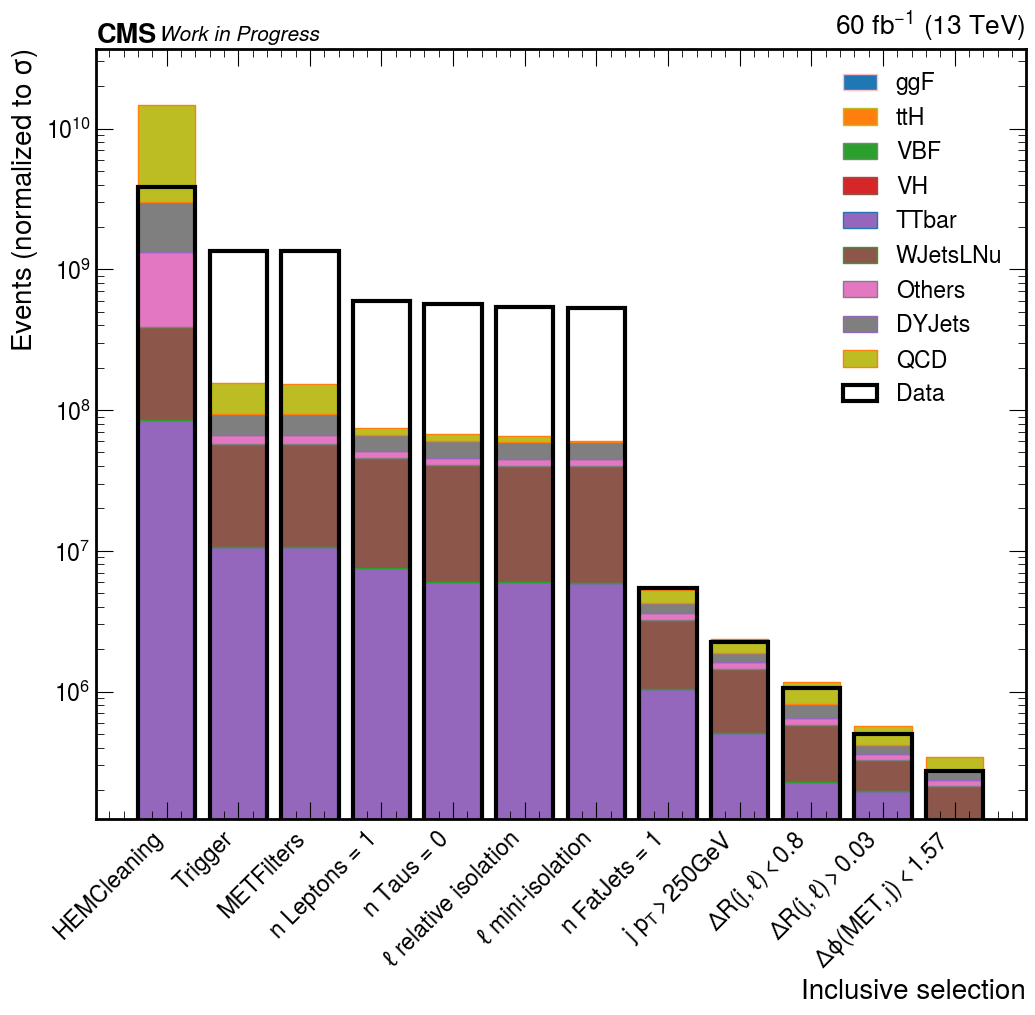

In [40]:
year = "2018"
ch = "lep"

samples = [
    "Data",
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "TTbar",
    "Others"    
#     "WZQQ",    
#     "SingleTop",
#     "Diboson",
]

labels = list(cutflows[year][ch][samples[0]].keys())  
values = [[cutflows[year][ch][sample][label] for label in labels] for sample in samples]
for i, lab in enumerate(labels):
    labels[i] = cut_to_label[lab]

# Sort the samples by yield
sorted_idx = sorted(range(len(values)), key=lambda i: sum(values[i]), reverse=False)
samples = [samples[i] for i in sorted_idx]
values = [values[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(12, 10))
# Plot the cutflows as a stacked bar chart for each sample
bottom = [0] * len(labels)
for i, sample in enumerate(samples):
    
    if sample=="Data":
#         ax.bar(labels, values[i], bottom=0, label=sample, linewidth=3, fill=False)
        continue
    else:
        ax.bar(labels, values[i], bottom=bottom, label=sample, edgecolor=color_by_sample[sample], linewidth=1, fill=True)
        bottom = [sum(x) for x in zip(bottom, values[i])]
    
    
for i, sample in enumerate(samples):
    
    if sample=="Data":
        ax.bar(labels, values[i], bottom=0, label=sample, linewidth=3, fill=False)
    else:
        continue
    
# ax.legend(title="Semi-leptonic channel")
ax.legend()

plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Inclusive selection')
ax.set_ylabel(r'Events (normalized to $\sigma$)')
ax.set_yscale("log")
# ax.set_ylim(1,10**11)
 
hep.cms.lumitext("%.0f " % get_lumi([year], [ch]) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)